In [1]:
# import sys
# print(sys.path)

In [2]:
# ------------------------------------------------------------------------------
# The code is based on HigherHRNet-Human-Pose-Estimation.
# (https://github.com/HRNet/HigherHRNet-Human-Pose-Estimation)
# Further modified by Jędrzej Warczyński
# ------------------------------------------------------------------------------


import os

import matplotlib.pyplot as plt
from collections import namedtuple

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torch.multiprocessing
from matplotlib import pyplot as plt
from dataset import HumanPoseDataset

from tqdm import tqdm

from lib import models as models

from src.lib.config import cfg
from src.lib.config import update_config
from src.lib.utils.utils import create_logger

from src.evaluation import infere_and_compute_oks
from src.evaluation import infere_and_reorder_joints
from src.visualization import show_prediction_with_gt
from src.visualization import show_prediction

### configuration for model loading

In [4]:
OPTS = ['TEST.MODEL_FILE', 'model/pose_crowdpose/pose_dekr_hrnetw32_crowdpose.pth', 'TEST.NMS_THRE', '0.15', 'TEST.SCALE_FACTOR', '0.5,1,2']
YAML_CFG = 'experiments/crowdpose/w32/w32_4x_reg03_bs10_512_adam_lr1e-3_crowdpose_x300.yaml'

args = namedtuple('args', ['cfg', 'opts'])
args.cfg = YAML_CFG
args.opts = OPTS

# print(os.getcwd())
update_config(cfg, args)

### Load model based on configuration

In [5]:
# cudnn related setting
cudnn.benchmark = cfg.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = cfg.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = cfg.CUDNN.ENABLED

logger, final_output_dir, _ = create_logger(cfg, args.cfg, 'valid')

model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=False
)

print(cfg.TEST.MODEL_FILE)
if cfg.TEST.MODEL_FILE:
    logger.info('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
    model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=True)
else:
    model_state_file = os.path.join(
        final_output_dir, 'model_best.pth.tar'
    )
    logger.info('=> loading model from {}'.format(model_state_file))
    model.load_state_dict(torch.load(model_state_file))

model = torch.nn.DataParallel(model, device_ids=cfg.GPUS).cuda()
model.eval()

=> creating output\crowd_pose_kpt\hrnet_dekr\w32_4x_reg03_bs10_512_adam_lr1e-3_crowdpose_x300
=> creating log\crowd_pose_kpt\hrnet_dekr\w32_4x_reg03_bs10_512_adam_lr1e-3_crowdpose_x300_2024-05-02-09-20


INFO:root:=> loading model from model/pose_crowdpose/pose_dekr_hrnetw32_crowdpose.pth
=> loading model from model/pose_crowdpose/pose_dekr_hrnetw32_crowdpose.pth


model/pose_crowdpose/pose_dekr_hrnetw32_crowdpose.pth


DataParallel(
  (module): PoseHigherResolutionNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [6]:
ROOT = '../res/dataset/train/train/'
dataset = HumanPoseDataset(root_dir=ROOT, train=True, transform=None)
dataset.__len__()

1350

### Compute OKS  metric for IR and RGB images

In [11]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

total_oks_IR = 0
total_oks_RGB = 0
for imgs, labels in tqdm(dataloader):
    original_IR_img = imgs.IR[0]
    original_RGB_img = imgs.RGB[0]
    gt_IR_torch = [l for l in labels.IR]
    gt_RGB_torch = [l for l in labels.RGB]

    osk_IR = infere_and_compute_oks(model, original_IR_img, cfg, gt_IR_torch)
    osk_RGB = infere_and_compute_oks(model, original_RGB_img, cfg, gt_RGB_torch)

    total_oks_IR += osk_IR
    total_oks_RGB += osk_RGB

print(total_oks_IR / len(dataloader))
print(total_oks_RGB / len(dataloader))

# with open('../out/oks_train.txt', 'w') as f:
#     f.write(f'IR: {total_oks_IR / len(dataloader)}\n')
#     f.write(f'RGB: {total_oks_RGB / len(dataloader)}')


  0%|          | 3/1350 [00:14<1:48:25,  4.83s/it]


KeyboardInterrupt: 

In [8]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
data_iter = iter(dataloader)

C:\Users\jedra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\jedra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


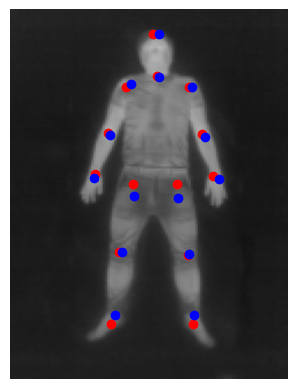

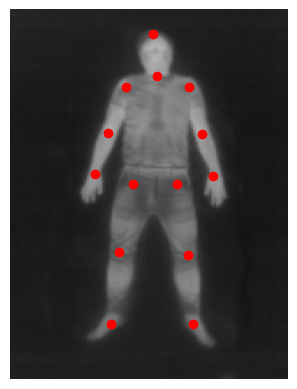

In [10]:
imgs, labels = next(data_iter)

original_IR_img = imgs.IR[0]
original_RGB_img = imgs.RGB[0]
gt_IR_torch = [l for l in labels.IR]
gt_RGB_torch = [l for l in labels.RGB]

skeleton = infere_and_reorder_joints(model, original_IR_img, cfg)
gt_skeleton = [(gt[0].cpu().numpy()[0], gt[1].cpu().numpy()[0]) for gt in gt_IR_torch]

show_prediction_with_gt(original_IR_img, skeleton, gt_skeleton)
show_prediction(original_IR_img, skeleton)